# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Multiple Linear Regression using MPI and OpenMP

## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the collective communication operations like scatter, gather, broadcast
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output.

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.

To know more about MPI click [here](https://hpc-tutorials.llnl.gov/mpi/)


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

In [292]:
# !pip install mpi4py


#### Importing Necessary Packages

In [293]:
# Importing pandas
import pandas as pd

# Importing Numpy
import numpy as np

# Importing MPI from mpi4py package
from mpi4py import MPI

# Importing sqrt function from the Math
from math import sqrt

# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time

import seaborn as sns
from matplotlib import pyplot as plt
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Pastel1_4

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle


#### Downloading the data

In [294]:
# @title Download the data
# !wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv


from utility import download_and_unzip

download_and_unzip(
    filename="PowerPlantData.csv",
    url="https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv",
)


False

### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Exercise 1: Load data (1 point)

Write a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.

**Hint:** read_csv()


In [295]:
# FILENAME = "/content/PowerPlantData.csv" # File path
FILENAME = "PowerPlantData.csv"  # File path


# YOUR CODE HERE to Define a function to load the data
# Function to load the data
def load_data(file_path):
    """
    Function to load the data from the given file path
    """
    # Load the data into a pandas DataFrame
    data = pd.read_csv(file_path, header=0, sep=",", engine="python")

    # Renaming columns in a DataFrame
    data.rename(
        columns={
            "AT": "AmbientTemperature",
            "V": "ExhaustVaccum",
            "AP": "AmbientPressure",
            "RH": "RelativeHumidity",
            "PE": "EnergyOutput",
        },
        inplace=True,
    )
    # Return the DataFrame
    return data


df = load_data(FILENAME)
df.head(5)  # Display the first 5 rows of the DataFrame


,AmbientTemperature,ExhaustVaccum,AmbientPressure,RelativeHumidity,EnergyOutput
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


#### Exercise 2: Explore data (1 point)

Write a function that takes the data loaded using the above defined function as input and explore it.

**Hint:** You can define and check for following things in the dataset inside a function

- checking for the number of rows and columns
- summary of the dataset
- check for the null values
- check for the duplicate values

In [296]:
# YOUR CODE HERE
def explore_data(df):
    """
    Function to explore the data
    """
    # Display the shape of the DataFrame
    print("Shape of the DataFrame:", df.shape)
    print("Number of rows:", df.shape[0])
    print("Number of columns:", df.shape[1])

    # Display the columns of the DataFrame
    print("\n\nColumns in the DataFrame:", df.columns.tolist())

    # Display the data types of each column
    print("\n\nData types of each column:")
    print(df.dtypes)

    print("\n\n Data statistics:")
    print(df.describe())

    # Find rows with null values
    null_rows = df[df.isnull().any(axis=1)]

    # Display rows with null values
    print("\n\nNo of rows with null values: {}".format(null_rows.shape[0]))

    # Find rows with any column having a value of zero
    rows_with_zero = df[(df == 0).any(axis=1)]

    # Display rows with zero values
    print("\n\nRows with zero values:".format(rows_with_zero.shape[0]))

    # Find duplicate rows
    duplicate_rows = df[df.duplicated()]

    # Display duplicate rows
    print("\n\nDuplicate number of rows: {}".format(duplicate_rows.shape[0]))
    print("\n\nDuplicate rows:")
    print(duplicate_rows)


explore_data(df)  # Call the function to explore the data


Shape of the DataFrame: (9568, 5)
Number of rows: 9568
Number of columns: 5


Columns in the DataFrame: ['AmbientTemperature', 'ExhaustVaccum', 'AmbientPressure', 'RelativeHumidity', 'EnergyOutput']


Data types of each column:
AmbientTemperature    float64
ExhaustVaccum         float64
AmbientPressure       float64
RelativeHumidity      float64
EnergyOutput          float64
dtype: object


 Data statistics:
       AmbientTemperature  ExhaustVaccum  AmbientPressure  RelativeHumidity  \
count         9568.000000    9568.000000      9568.000000       9568.000000   
mean            19.651231      54.305804      1013.259078         73.308978   
std              7.452473      12.707893         5.938784         14.600269   
min              1.810000      25.360000       992.890000         25.560000   
25%             13.510000      41.740000      1009.100000         63.327500   
50%             20.345000      52.080000      1012.940000         74.975000   
75%             25.720000      66.5

#### Exercise 3: Handle missing data (1 point)

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.

**Hint:**

- Drop the records containing the null values - dropna()
- Replace the null values with the mean/median/mode - fillna()

In [297]:
# Function to handle missing data


def clean_data(df):
    """
    Function to clean the data
    """
    print("before dropping missing values: {}".format(df.shape))
    df_ = df.dropna().reset_index(drop=True)  # Drop rows with missing values
    print("after dropping missing values {}".format(df_.shape))
    df_ = df.drop_duplicates().reset_index(drop=True)
    print("after dropping duplicate values {}".format(df_.shape))
    return df_


df = clean_data(df)


before dropping missing values: (9568, 5)
after dropping missing values (9568, 5)
after dropping duplicate values (9527, 5)


#### Exercise 4: Scale the data (1 point)

Write a function that takes the data after handling the missing data as input and returns the standardized data.

**Hint:**

- standardization of the data  can be performed using the below formula

$ (x - mean(x)) / std(x) $

In [298]:
# Defining a function to standardize the data

# YOUR CODE HERE
def scale_data(df):
    """
    Function to standardize the data
    """
    # Standardizing the data
    df_ = (df - df.mean()) / df.std()
    return df_


df = scale_data(df)  # Call the function to standardize the data
df.describe()  # Display the statistics of the DataFrame


,AmbientTemperature,ExhaustVaccum,AmbientPressure,RelativeHumidity,EnergyOutput
count,9.527000e+03,9.527000e+03,9.527000e+03,9.527000e+03,9.527000e+03
mean,4.389151e-16,-2.535788e-16,8.927466e-15,-8.875258e-16,9.867199e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.397538e+00,-2.280681e+00,-3.425132e+00,-3.270574e+00,-1.999868e+00
25%,-8.231996e-01,-9.895251e-01,-6.989422e-01,-6.818376e-01,-8.560268e-01
50%,9.292559e-02,-1.744732e-01,-5.337643e-02,1.139858e-01,-1.652618e-01
75%,8.129302e-01,9.629735e-01,6.670985e-01,7.882963e-01,8.233479e-01
max,2.344283e+00,2.149292e+00,3.377296e+00,1.836387e+00,2.431122e+00


#### Exercise 5: Feature selection (1 point)

Write a function that takes scaled data as input and returns the features and target variable values

**Hint:**

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity
- Target Variable: EnergyOutput

In [299]:
# Define a function
def split_data_into_X_and_Y(df):
    """
    Function to split the data into X and Y
    """
    # Extracting the target column as Y and remaining columns as X
    target_column = "EnergyOutput"  # Replace with the name of your target column
    X = df.drop(columns=[target_column])  # Features
    Y = df[target_column]  # Target

    return X, Y


X, Y = split_data_into_X_and_Y(df)  # Call the function to split the data

# Display the shapes of X and Y
print("Shape of X (features):", X.shape)
print("Shape of Y (target):", Y.shape)


Shape of X (features): (9527, 4)
Shape of Y (target): (9527,)


#### Exercise 6: Correlation (1 point)

Calculate correlation between the variables

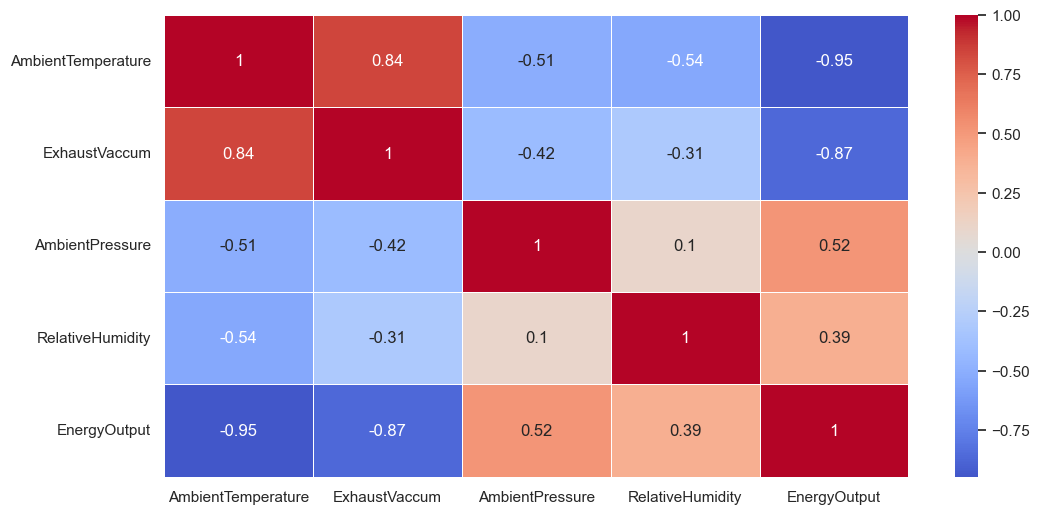

In [300]:
# YOUR CODE HERE
# plot the heat map


def create_correlation_heatmap(df):
    """
    Function to create a correlation heatmap
    """
    # sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, linewidth=0.5, center=0, cmap="coolwarm")
    plt.show()


create_correlation_heatmap(df)  # Call the function to create a heatmap


#### Exercise 7: Estimate the coefficients (2 points)

Write a function that takes features and target as input and returns the estimated coefficient values

**Hint:**

- Calculate the estimated coefficients using the below formula

$ β = (X^T X)^{-1} X^T y $

- transpose(), np.linalg.inv()

In [301]:
# Calculating the coeffients

# YOUR CODE HERE
def estimate_coefficients(X, Y):
    # Calculate the coefficients using the formula
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ Y

    return coefficients


coefficients = estimate_coefficients(X, Y)
print("Estimated Coefficients:", coefficients)


Estimated Coefficients: 0   -0.862254
1   -0.175757
2    0.021112
3   -0.134864
dtype: float64


#### Exercise 8: Fit the data to estimate the coefficients (2 points)

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.

**Hint:**

- create a dummy column in the features dataframe which is made up of all ones
- convert the features dataframe into numpy array
- call the estimated coefficients function which is defined above
- np.ones(), np.concatenate()

In [302]:
# defining a fit function
def fit(x, y):
    # YOUR CODE HERE
    # Add a column of ones to X for the intercept term
    print(x, x.shape)
    x = np.hstack((np.ones((x.shape[0], 1)), x))
    print(x, x.shape)
    coefficients = estimate_coefficients(x, y)
    return coefficients


# Call the fit function
coefficients = fit(X, Y)
c = coefficients[0]
m = coefficients[1:]
print("Estimated intercept:", c)
print("Estimated Coefficients:", m)


      AmbientTemperature  ExhaustVaccum  AmbientPressure  RelativeHumidity
0              -1.520368      -1.065985        -0.403514          1.141539
1               0.534869       0.330796        -0.309246          0.059219
2               1.354277       0.205464        -1.024671         -2.151287
3              -0.079016      -0.362865        -1.012887          0.236525
4              -1.055589      -1.074656         0.655315          1.633752
...                  ...            ...              ...               ...
9522           -0.609616      -0.423561        -0.241912         -0.027722
9523            1.847265       1.864733        -0.494415         -0.932051
9524           -0.492750      -0.863405         0.162093          0.364542
9525           -0.269763       0.439575         0.899401          1.459184
9526            0.540242      -0.235957        -0.231812         -0.143416

[9527 rows x 4 columns] (9527, 4)
[[ 1.         -1.52036826 -1.06598545 -0.40351377  1.14153919]
 [

#### Exercise 9: Predict the data on estimated coefficients (1 point)

Write a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.

**Hint:**

- Fit the intercept, coefficients values in the below equation

  $y = b_0 + b_1*x + ... + b_i*x_i$

In [303]:
# fucntion to predict the values
def predict(x, intercept, coefficients):
    """
    y = b_0 + b_1*x + ... + b_i*x_i
    """
    # YOUR CODE HERE
    predictions = intercept + np.dot(x, coefficients)
    return predictions


In [304]:
X.head(5)  # Display the first 5 rows of the DataFrame


,AmbientTemperature,ExhaustVaccum,AmbientPressure,RelativeHumidity
0,-1.520368,-1.065985,-0.403514,1.141539
1,0.534869,0.330796,-0.309246,0.059219
2,1.354277,0.205464,-1.024671,-2.151287
3,-0.079016,-0.362865,-1.012887,0.236525
4,-1.055589,-1.074656,0.655315,1.633752


In [305]:
# x1 = X.iloc[0].to_numpy().reshape(1, -1)
x1 = X.iloc[0].to_numpy()
x1


array([-1.52036826, -1.06598545, -0.40351377,  1.14153919])

In [306]:
predicted_value = predict(x1, c, m)  # Call the function to predict the values
print("Predicted value:", predicted_value)


Predicted value: 1.3358248817057714


In [307]:
predicted_value = predict(X, c, m)
print("Predicted value:", predicted_value)
print("number of predicted values: {}".format(predicted_value.size))


Predicted value: [ 1.33582488 -0.53384742 -0.93534243 ...  0.53088277 -0.02245769
 -0.40990677]
number of predicted values: 9527


In [308]:
print(Y.dtype)
print(type(Y))
Y.name = "EnergyOutput"
print(Y.head(5))


float64
<class 'pandas.core.series.Series'>
0    1.534360
1   -0.503895
2   -0.914129
3   -0.073121
4    0.592408
Name: EnergyOutput, dtype: float64


In [309]:
print(predicted_value.dtype)
print(type(predicted_value))


float64
<class 'numpy.ndarray'>


In [310]:
# Create the figure
p = figure(title="Actual vs Predicted Power Output", width=900, height=600)
p.title.align = "center"

# Plot actual power output using scatter
p.scatter(
    X.AmbientTemperature,
    Y,
    color=Pastel1_4[0],
    alpha=0.6,
    fill_alpha=0.6,
    line_color="black",
    line_width=1,
    marker="circle",
    fill_color=Pastel1_4[0],
    size=4,
    legend_label="Actual Power Output",
)

# Plot predicted power output using scatter
p.scatter(
    X.AmbientTemperature,
    pd.Series(predicted_value),
    color=Pastel1_4[1],
    alpha=0.6,
    fill_alpha=0.6,
    line_color="black",
    line_width=1,
    marker="triangle",
    fill_color=Pastel1_4[1],
    size=4,
    legend_label="Predicted Power Output",
)

# Set axis labels
p.xaxis.axis_label = "Ambient Temperature"
p.yaxis.axis_label = "Power Output"

output_notebook()
# Show the plot
show(p)


Loading BokehJS ...

#### Exercise 10: Root mean squared error (1 point)

Write a function to calculate the RMSE error.

**Hint:**

- [How to calculate the RSME error](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [311]:
# Define a function to calculate the error

# YOUR CODE HERE
def calculate_rmse(y_true, y_pred):
    rmse_value_1 = np.sqrt(np.mean(np.square(y_true - y_pred)))
    rmse_value_1

    rmse_value_2 = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_value_2
    return rmse_value_1


print("RMSE value: {}".format(calculate_rmse(Y, predicted_value)))


RMSE value: 0.26752544372182074


#### Exercise 11: Split the data into train and test (1 point)

Write a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.

**Hint:**

- Shuffle the data
- Consider 70 % of data as a train set and the rest of the data as a test set

In [312]:
# YOUR CODE HERE


def train_test_split(X, Y, train_size=0.7):
    X, Y = shuffle(X, Y, random_state=42)
    split_index = int(len(X) * train_size)

    # Split the data into train and test sets
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    return X_train, X_test, Y_train, Y_test


X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Display the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (6668, 4)
X_test shape: (2859, 4)
Y_train shape: (6668,)
Y_test shape: (2859,)


#### Exercise 12: Implement predict using OpenMP (1 point)

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

**Hints:**

* Using the pymp.Parallel implement the predict function (use from above)

* Call the predict function by passing test data as an argument

* calculate the error (RMSE) by comparing the Actual test data and predicted test data

In [ ]:
!pip install pymp-pypi


In [ ]:
import pymp
# YOUR CODE HERE


#### Exercise 13: Create a communicator (1 point)

Create a comunicator and define the rank and size

In [ ]:
# YOUR CODE HERE


#### Exercise 14: Divide the data into slices (1 point)

Write a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio

**Hint:**

- Divide the Data equally among the workers
  - Create an empty list
  - Iterate over the size of workers
  - Append each slice of data to the list

In [ ]:
def dividing_data(x_train, y_train, size_of_workers):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    # YOUR CODE HERE


#### Exercise 15: Prepare the data in root worker to assign data for all the workers (1 point)

- When it is the root worker, perform the below operation:
    - Store the features and target values in separate variables
    - Split the data into train and test sets using the train_test_split function defined above
    - Divide the data among the workers using the dividing_data function above

In [ ]:
# YOUR CODE HERE


#### Exercise 16: Scatter and gather the data (1 point)

Perform the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker
    - **Hint:** scatter()
    - use `barrier()` to block workers until all workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- Get the new coefficient of each instance in a slice
    - **Hint:** fit function defined above
- Gather the new coefficient from each worker
    - **Hint:** gather()
    - Take the mean of the gathered coefficients
- Calculate the root mean square error for the test set

To know more about `scatter`, `gather` and `barrier` click [here](https://nyu-cds.github.io/python-mpi/05-collectives/)

In [ ]:
# YOUR CODE HERE


#### Exercise 17: Make a script and execute everything in one place (1 point)

Write a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.

**Hint:**

- magic commands
- put MPI related code under main function
- !mpirun --allow-run-as-root -np 4 python filename.py

In [ ]:
# YOUR CODE HERE for scipt(.py)


In [ ]:
# YOUR CODE HERE for MPI command


#### Exercise 18: Use Sklearn to compare (1 point)

Apply the Linear regression on the given data using sklearn package and compare with the above results

**Hint:**
* Split the data into train and test
* Fit the train data and predict the test data using `sklearn Linear Regression`
* Compare the coefficients and intercept with above estimated coefficients
* calculate loss (RMSE) on test data and predictions and compare

In [ ]:
# YOUR CODE HERE
